## imports

In [874]:
from pymongo import MongoClient
import os
from dotenv import load_dotenv
import re
import nltk
import pandas as pd
import string
import matplotlib.pyplot as plt
import numpy as np

In [7]:
load_dotenv()

True

In [781]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation, PCA
from sklearn.metrics.pairwise import cosine_similarity
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

import spacy
from spacy import displacy
from collections import Counter

In [143]:
import en_core_web_md

# Load data from MongoDB

In [149]:
host = os.getenv('host')
pwd = os.getenv('mongo_pwd')

In [150]:
config = {
  'host': host+':27017',
  'username': 'mongo_user',
  'password': pwd,
  'authSource': 'proj4'
}

In [151]:
client = MongoClient(**config)

In [152]:
client.list_database_names()

['proj4']

In [153]:
db = client.proj4

In [154]:
db.list_collection_names()

['invisible', 'ninetynine']

## Load episodes from ninetynine collection

In [155]:
episodes = list(db.ninetynine.find())

In [959]:
len(episodes)

401

# Parse Transcripts
The text for each episode was scraped as a single string. Speakers are annotated in the transcript. The text needs to be parsed to remove that annotation. 

In [963]:
def parse_transcript_all(string):   
    content = []
    content_list = string.split('\n')
    
    line = dict()
    
    for entry in content_list:
        
        entry = entry.strip()
        
        if line:    #Check if line is not empty.
            line['text'] = entry
            content.append(line)
            line = dict()
            
        elif entry.find(':') >= 0:
            if entry.find(':')+1 == len(entry):
                line['speaker'] = entry
            else:
                line['speaker'] = entry[:entry.find(':')+1]
                line['text'] = entry[entry.find(':')+1:]
                content.append(line)
                line = dict()
        else:
            line['speaker'] = 'Clip'
            line['text'] = entry
            content.append(line)
            line = dict()
    
    return content

## Use parse function on each episode
Used a for loop to parse all transcripts. A new dataframe was made with the individual lines spoken in each podcast as a new row. 

In [964]:
parsed_episodes = []

for episode in episodes:
    parsed_ep = parse_transcript_all(episode['transcript'])
    for line in parsed_ep:
        line['title'] = episode['title']
        line['category'] = episode['category']
        line['date'] = episode['date']
        line['producer'] = episode['producer']
        line['episode_number'] = episode['episode_number']
        
        parsed_episodes.append(line)

In [965]:
corpus = pd.DataFrame(parsed_episodes)

In [966]:
corpus.shape

(42035, 7)

# Preliminary cleaning to clean up after parsing

## Drop empty text
Some of the text where just empty strings after parsing. This happened at the start and end of each episode transcript.


In [18]:
corpus = corpus.drop(index=corpus[(corpus.text == '')].index, axis=0)

## Drop clips and sound descriptions
The transcrpit included sound annotation that need to be removed.

In [20]:
drop_index = []

In [22]:
drop_index.extend(corpus[(corpus.text.apply(lambda x: x.find('Clip'))>=0)].index)

In [24]:
drop_index.extend(corpus[(corpus.text.apply(lambda x: x.find('[BREAK]'))>=0)].index)

In [25]:
drop_index.extend(corpus[(corpus.text.apply(lambda x: x.find('[MUSIC]'))>=0)].index)

In [26]:
drop_index.extend(corpus[(corpus.text.apply(lambda x: x.find('['))==0)].index)

In [27]:
corpus = corpus.drop(index=drop_index, axis=0)

In [28]:
corpus = corpus.reset_index(drop=True)

In [29]:
corpus.shape

(40791, 7)

# Clean text


In [30]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [31]:
data_clean = pd.DataFrame(corpus.text.apply(round1))
data_clean

,text
0,this is invisible i’m roman mars
1,on any given day there are a few different kin...
2,that’s the song ‘solidarity’ by the band screa...
3,“baby shark doo doo doo doo doo doo
4,baby shark doo doo doo doo doo doo
...,...
40786,it’s a healthy debate
40787,it’s part of architecture it’s part of culture
40788,yeah exactly when do we look towards the past ...
40789,that being said time always moves forward and ...


In [32]:
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [33]:
data_clean = pd.DataFrame(data_clean.text.apply(round2))
data_clean

,text
0,this is invisible im roman mars
1,on any given day there are a few different kin...
2,thats the song solidarity by the band scream o...
3,baby shark doo doo doo doo doo doo
4,baby shark doo doo doo doo doo doo
...,...
40786,its a healthy debate
40787,its part of architecture its part of culture
40788,yeah exactly when do we look towards the past ...
40789,that being said time always moves forward and ...


In [34]:
data_clean.to_csv('data_clean.csv')

In [35]:
corpus.loc[:,'text'] = data_clean.text

In [36]:
corpus

,speaker,text,title,category,date,producer,episode_number
0,Roman Mars:,this is invisible im roman mars,Whomst Among Us Let The Dogs Out,Sounds,02.11.20,Chris Berube,Episode 389
1,Roman Mars:,on any given day there are a few different kin...,Whomst Among Us Let The Dogs Out,Sounds,02.11.20,Chris Berube,Episode 389
2,Roman Mars:,thats the song solidarity by the band scream o...,Whomst Among Us Let The Dogs Out,Sounds,02.11.20,Chris Berube,Episode 389
3,Clip,baby shark doo doo doo doo doo doo,Whomst Among Us Let The Dogs Out,Sounds,02.11.20,Chris Berube,Episode 389
4,Clip,baby shark doo doo doo doo doo doo,Whomst Among Us Let The Dogs Out,Sounds,02.11.20,Chris Berube,Episode 389
...,...,...,...,...,...,...,...
40786,Kate Wagner:,its a healthy debate,Fraktur,History,02.18.20,99pi,Episode 390
40787,Roman Mars:,its part of architecture its part of culture,Fraktur,History,02.18.20,99pi,Episode 390
40788,Kate Wagner:,yeah exactly when do we look towards the past ...,Fraktur,History,02.18.20,99pi,Episode 390
40789,Kate Wagner:,that being said time always moves forward and ...,Fraktur,History,02.18.20,99pi,Episode 390


In [37]:
corpus.to_csv('corpus.csv')

# Combine episode text
I decided to combined the text back together into episodes and model on the episodes as a whole.

## list of episode titles

In [38]:
ep_titles = []
for ep in episodes:
    ep_titles.append(ep['title'])

## group by titles

In [39]:
ep_grouped = corpus.groupby('title')

In [40]:
corpus_by_episode = []
for ep_title in ep_titles:
    ep = dict()
    single_ep = ep_grouped.get_group(ep_title).reset_index()
    ep['title'] = single_ep.title[0]
    ep['category'] = single_ep.category[0]
    ep['date'] = single_ep.date[0]
    ep['producer'] = single_ep.producer[0]
    ep['episode_number'] = single_ep.episode_number[0]
    ep['text'] = ' '.join(single_ep.text)
    
    corpus_by_episode.append(ep)

In [41]:
corpus_by_episode = pd.DataFrame(corpus_by_episode)

In [42]:
corpus_by_episode.to_csv('corpus_by_episode.csv')

In [49]:
corpus_by_episode = corpus_by_episode.set_index('title')

In [14]:
corpus_by_episode = pd.read_csv('corpus_by_episode.csv', index_col=0)
corpus_by_episode = corpus_by_episode.set_index('title')

# Preliminary Analysis

## Vectorize

In [16]:
cv1 = CountVectorizer(stop_words='english')
text_cv1 = cv1.fit_transform(corpus_by_episode.text)

In [17]:
cv_corpus = pd.DataFrame(text_cv1.toarray(), columns=cv1.get_feature_names(), index=corpus_by_episode.index)

## Top words in each episode

In [18]:
top_dict = {}
data = cv_corpus.T

for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

In [20]:
for episode, top_words in top_dict.items():
    print(episode)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

Whomst Among Us Let The Dogs Out
dogs, song, let, like, just, kind, theres, yeah, think, question, people, really, thats, baha
---
Missing the Bus
bus, transit, people, really, think, like, cities, just, lot, buses, make, thats, theres, going
---
The Worst Video Game Ever
game, atari, et, video, howard, games, know, like, right, just, people, time, really, home
---
Their Dark Materials
like, kapoor, black, anish, vantablack, just, make, really, titanium, world, material, art, dioxide, work
---
Shade
city, shade, los, angeles, tree, people, just, trees, like, think, way, space, things, neighborhood
---
Mini-Stories: Volume 8
like, just, yeah, actually, thats, bond, right, people, really, alamos, think, los, theyre, lot
---
Mini-Stories: Volume 7
like, just, sign, thats, hollywood, people, yeah, actually, really, theyre, right, park, oh, theres
---
The ELIZA Effect
like, people, weizenbaum, know, just, human, really, computer, time, computers, think, eliza, make, language
---
The Infanto

## Adding to Stop words

In [21]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for each comedian
words = []
for episode in data.columns:
    top = [word for (word, count) in top_dict[episode]]
    for t in top:
        words.append(t)

In [22]:
words

['dogs',
 'song',
 'let',
 'like',
 'just',
 'kind',
 'theres',
 'yeah',
 'think',
 'question',
 'people',
 'really',
 'thats',
 'baha',
 'men',
 'know',
 'oh',
 'doo',
 'going',
 'actually',
 'im',
 'steve',
 'did',
 'called',
 'douglas',
 'heard',
 'got',
 'dont',
 'mark',
 'miami',
 'bus',
 'transit',
 'people',
 'really',
 'think',
 'like',
 'cities',
 'just',
 'lot',
 'buses',
 'make',
 'thats',
 'theres',
 'going',
 'way',
 'dont',
 'public',
 'city',
 'experience',
 'new',
 'things',
 'better',
 'service',
 'sort',
 'street',
 'access',
 'problem',
 'know',
 'talking',
 'actually',
 'game',
 'atari',
 'et',
 'video',
 'howard',
 'games',
 'know',
 'like',
 'right',
 'just',
 'people',
 'time',
 'really',
 'home',
 'thats',
 'theres',
 'im',
 'company',
 'desert',
 'oh',
 'make',
 'sidedoor',
 'history',
 'jason',
 'american',
 'laughs',
 'did',
 'play',
 'kind',
 'didnt',
 'like',
 'kapoor',
 'black',
 'anish',
 'vantablack',
 'just',
 'make',
 'really',
 'titanium',
 'world',
 

In [23]:
Counter(words).most_common()

[('like', 365),
 ('just', 363),
 ('people', 301),
 ('thats', 252),
 ('really', 242),
 ('know', 217),
 ('time', 192),
 ('think', 162),
 ('new', 152),
 ('way', 144),
 ('going', 140),
 ('kind', 128),
 ('im', 122),
 ('dont', 120),
 ('lot', 110),
 ('actually', 103),
 ('right', 102),
 ('city', 92),
 ('theres', 90),
 ('years', 86),
 ('make', 80),
 ('got', 78),
 ('design', 74),
 ('little', 72),
 ('building', 71),
 ('theyre', 70),
 ('things', 68),
 ('did', 60),
 ('world', 59),
 ('thing', 59),
 ('youre', 56),
 ('yeah', 54),
 ('look', 54),
 ('called', 48),
 ('didnt', 47),
 ('said', 47),
 ('say', 46),
 ('sort', 44),
 ('want', 44),
 ('work', 41),
 ('says', 38),
 ('good', 35),
 ('story', 34),
 ('place', 34),
 ('public', 33),
 ('big', 33),
 ('started', 32),
 ('day', 32),
 ('mean', 32),
 ('york', 31),
 ('use', 29),
 ('buildings', 29),
 ('sound', 27),
 ('space', 26),
 ('different', 26),
 ('architecture', 26),
 ('come', 26),
 ('music', 26),
 ('san', 26),
 ('used', 26),
 ('house', 24),
 ('francisco', 24)

In [24]:
add_stop_words = [word for word, count in Counter(words).most_common() if count > 100]
add_stop_words

['like',
 'just',
 'people',
 'thats',
 'really',
 'know',
 'time',
 'think',
 'new',
 'way',
 'going',
 'kind',
 'im',
 'dont',
 'lot',
 'actually',
 'right']

In [208]:
more_stop_words = ['roman','mars','invisible','yeah','avery','trufelman','kalw','radio','row']

stop_words = ENGLISH_STOP_WORDS.union(add_stop_words, more_stop_words)

len(stop_words)

344

# Wordcloud

In [81]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [ ]:
plt.rcParams['figure.figsize'] = [16, 202]

full_names = list(corpus_by_episode.index)

for index, episode in enumerate(data.columns):
    wc.generate(corpus_by_episode.text[episode])
    
    plt.subplot(101, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])

plt.savefig('wordcloud.png')

# Topic Modeling

In [28]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '", topic_names[ix], "'")
        print(", ".join([
            feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]
        ]))

## Countvectorizer with LSA and NMF

### 2 Topics; 1,2 ngrams

In [29]:
ngrams=(1,2)
max_df=1
num_topics = 2

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df)
corpus_cv2 = cv2.fit_transform(corpus_by_episode.text)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [112]:
print(f'Topics:{num_topics} Ngrams:{ngrams} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),5)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),5)

Topics:2 Ngrams:(1, 2) 
____________

LSA topics

Topic  0
make, called, theres, years, got

Topic  1
radio row, row beautiful, francisco produced, produced radio, frank lloyd
____________

NMF topics

Topic  0
make, called, theres, years, got

Topic  1
avery, kalw, trufelman, avery trufelman, kalw san


### 2 Topics

In [29]:
ngrams=(1,1)
max_df=1
num_topics = 2

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df)
corpus_cv2 = cv2.fit_transform(corpus_by_episode.text)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [118]:
print(f'Topics:{num_topics} Ngrams:{ngrams} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),5)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),5)

Topics:2 Ngrams:(1, 1) 
____________

LSA topics

Topic  0
make, called, theres, years, got

Topic  1
buildings, cities, land, homes, city
____________

NMF topics

Topic  0
make, thing, say, got, called

Topic  1
place, city, building, years, didnt


### 2 Topics; lower max_df

In [29]:
ngrams=(1,1)
max_df=.5
num_topics = 2

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df)
corpus_cv2 = cv2.fit_transform(corpus_by_episode.text)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [127]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),7)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),7)

Topics:2 Ngrams:(1, 1) max_df:0.5 
____________

LSA topics

Topic  0
days, heard, beautiful, ways, looks, quite, means

Topic  1
buildings, cities, homes, houses, land, architect, urban
____________

NMF topics

Topic  0
youve, important, using, try, example, comes, sound

Topic  1
build, places, buildings, cities, house, government, began


added more stop words

### 3 Topics

In [29]:
ngrams=(1,1)
max_df=.5
num_topics = 3

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df)
corpus_cv2 = cv2.fit_transform(corpus_by_episode.text)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [152]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),10)

Topics:3 Ngrams:(1, 1) max_df:0.5 
____________

LSA topics

Topic  0
days, heard, beautiful, ways, looks, quite, means, told, try, couple

Topic  1
buildings, cities, homes, land, houses, architect, build, urban, construction, neighborhood

Topic  2
architecture, architects, art, francisco, cool, style, architectural, original, architect, beautiful
____________

NMF topics

Topic  0
youve, important, using, try, sound, comes, example, interesting, totally, hear

Topic  1
build, places, outside, cities, government, buildings, house, living, began, area

Topic  2
architecture, architects, francisco, beautiful, san, art, style, architect, buildings, cool


### 3 Topics plus ngrams 

In [39]:
ngrams=(1,2)
max_df=.5
num_topics = 3

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df)
corpus_cv2 = cv2.fit_transform(corpus_by_episode.text)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [40]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),10)

Topics:3 Ngrams:(1, 2) max_df:0.5 
____________

LSA topics

Topic  0
heard, days, beautiful, ways, looks, quite, told, means, try, couple

Topic  1
southern california, story idea, giddy, architecture course, getting started, suburban backyard, california having, sumptuous, norton, jake

Topic  2
roofs, housing, cookiecutter, end life, bare, heating, guggenheim, commissions, wright designed, dining room
____________

NMF topics

Topic  0
days, heard, try, beautiful, ways, quite, couple, important, told, means

Topic  1
architecture, san francisco, san, francisco, california, architects, downtown, oakland california, francisco produced, mingle

Topic  2
architect, buildings, architecture, windows, architects, house, houses, homes, housing, construction


### 4 Topics

In [52]:
ngrams=(1,1)
max_df=.5
num_topics = 4

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df)
corpus_cv2 = cv2.fit_transform(corpus_by_episode.text)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [53]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),10)

Topics:4 Ngrams:(1, 1) max_df:0.5 
____________

LSA topics

Topic  0
days, heard, beautiful, ways, looks, quite, means, told, try, couple

Topic  1
buildings, cities, homes, land, houses, architect, build, urban, north, neighborhood

Topic  2
architecture, architects, francisco, art, cool, studio, style, architect, architectural, san

Topic  3
friends, guys, mother, woman, died, knew, family, night, held, parents
____________

NMF topics

Topic  0
youve, sound, interesting, important, comes, using, example, try, hear, totally

Topic  1
architecture, buildings, architect, architects, architectural, beautiful, windows, build, looks, center

Topic  2
oakland, sean, california, fitzgerald, friend, produced, san, guys, fun, beautiful

Topic  3
government, united, began, places, states, eventually, america, family, community, hundreds


### 5 Topics

In [89]:
ngrams=(1,1)
max_df=.5
num_topics = 5

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df)
corpus_cv2 = cv2.fit_transform(corpus_by_episode.text)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [90]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),10)

Topics:5 Ngrams:(1, 1) max_df:0.5 
____________

LSA topics

Topic  0
days, heard, beautiful, ways, looks, quite, means, told, try, couple

Topic  1
buildings, cities, land, homes, houses, architect, build, north, urban, construction

Topic  2
architecture, architects, francisco, art, cool, style, original, architectural, architect, studio

Topic  3
friends, guys, mother, died, parents, watching, knew, held, family, woman

Topic  4
lived, class, daughter, art, born, culture, generation, loved, true, character
____________

NMF topics

Topic  0
youve, sound, important, interesting, using, example, comes, play, hear, try

Topic  1
buildings, build, architecture, francisco, san, beautiful, feet, cities, massive, open

Topic  2
friend, art, style, beautiful, sean, oakland, california, fun, famous, produced

Topic  3
government, family, began, united, group, states, war, eventually, community, taken

Topic  4
house, style, windows, architect, architecture, buildings, true, architects, looks

### 8 Topics

In [109]:
ngrams=(1,1)
max_df=.5
num_topics = 8

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df)
corpus_cv2 = cv2.fit_transform(corpus_by_episode.text)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [110]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),10)

Topics:8 Ngrams:(1, 1) max_df:0.5 
____________

LSA topics

Topic  0
days, heard, beautiful, ways, looks, quite, means, told, try, couple

Topic  1
buildings, cities, homes, land, houses, architect, build, urban, north, construction

Topic  2
architecture, francisco, architects, art, cool, san, original, architectural, architect, style

Topic  3
guys, friends, everybody, morning, weeks, mother, woman, watching, family, record

Topic  4
art, word, style, met, felt, lived, draw, night, father, room

Topic  5
states, united, industry, culture, cultural, spread, grown, historian, groups, mother

Topic  6
died, continued, europe, writing, brought, eventually, press, war, incredibly, picked

Topic  7
americans, believed, united, states, simply, information, problems, learning, starting, described
____________

NMF topics

Topic  0
youve, sound, interesting, play, important, using, example, comes, hear, favorite

Topic  1
build, cities, san, buildings, area, space, water, places, feet, massi

### 10 Topics

In [327]:
ngrams=(1,1)
max_df=.5
num_topics = 10

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df)
corpus_cv2 = cv2.fit_transform(corpus_by_episode.text)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [328]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),10)

Topics:10 Ngrams:(1, 1) max_df:0.5 
____________

LSA topics

Topic  0
days, heard, beautiful, ways, looks, quite, means, told, try, couple

Topic  1
buildings, cities, homes, land, houses, architect, build, urban, north, construction

Topic  2
architecture, art, architects, cool, style, studio, original, architectural, architect, beautiful

Topic  3
human, create, using, century, creating, architecture, technology, shape, space, designing

Topic  4
art, lived, met, felt, daughter, night, father, style, word, knew

Topic  5
site, feet, id, dead, light, standing, killed, died, open, windows

Topic  6
began, held, study, europe, language, hundreds, war, thousands, continued, helped

Topic  7
check, original, moving, tower, window, technology, air, massive, amazing, skyscrapers

Topic  8
architecture, downtown, bad, architect, wrong, minute, architectural, urban, walking, produced

Topic  9
buy, business, sell, selling, production, money, massive, industry, companies, kid
____________

NM

### 12 Topics

In [707]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 12

cv2 = CountVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df, min_df=min_df)
corpus_cv2 = cv2.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_cv2)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_cv2)

In [708]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} \n____________\n\nLSA topics')
display_topics(lsa, cv2.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, cv2.get_feature_names(),10)

Topics:12 Ngrams:(1, 1) max_df:0.8 
____________

LSA topics

Topic  0
place, story, idea, life, today, work, course, fact, point, city

Topic  1
audience, information, music, sound, type, device, technology, computer, conversation, example

Topic  2
family, morning, community, night, men, government, kid, president, week, parent

Topic  3
government, science, scientist, issue, study, technology, university, problem, rate, research

Topic  4
century, culture, father, book, society, history, historian, art, child, symbol

Topic  5
company, industry, machine, production, product, technology, worker, business, ton, market

Topic  6
market, money, window, store, care, floor, student, class, business, law

Topic  7
room, hour, child, mile, air, society, engineer, future, body, program

Topic  8
york, office, building, city, street, information, group, word, bit, newspaper

Topic  9
face, heart, experience, success, scene, plan, chance, control, opportunity, mind

Topic  10
night, sense, cho

In [54]:
H = pd.DataFrame(doc_topic_nmf.round(5),
             index = corpus_by_episode.index,
             #columns = ["component_1","component_2" ]
    )

In [59]:
H.sort_values(3,ascending=False).head(10)

,0,1,2,3
title,,,,
Model City,0.00000,0.19858,0.24960,2.51721
Bundyville,0.24143,0.00000,0.09963,1.85439
The Tunnel,0.00000,0.57954,0.13694,1.82585
Turf Wars of East New York,0.00220,0.18755,0.10828,1.61720
Post-Narco Urbanism,0.00000,0.00000,0.01352,1.58813
"Church (Sanctuary, Part 1)",0.00000,0.00000,0.00000,1.54465
It’s Chinatown,0.13149,0.56826,0.00000,1.48769
Fire and Rain,0.00000,0.28654,0.00000,1.44525
Manzanar,0.00000,0.09829,0.03001,1.41932


In [549]:
ep_num = list(corpus_by_episode.episode_number.apply(remove_ep))

# Remove duplicate episodes
Found that several episodes were reruns. A few with added stories. I kept the later airing. 

In [592]:
def remove_ep(string):
    return string.strip('Episode ')

In [596]:
corpus_by_episode.episode_number = corpus_by_episode.episode_number.apply(remove_ep)

In [602]:
corpus_by_episode.date = pd.to_datetime(corpus_by_episode.date)

In [550]:
dups =[]
for ep in ep_num:
    if ep_num.count(ep) > 1:
        dups.append(ep)

In [553]:
set(dups)

{'', '110', '200', '281', '54'}

In [577]:
titles = list(corpus_by_episode.index)

In [578]:
redux = []
for title in titles:
    if title.lower().find('redux') >=0:
        redux.append(title)

In [581]:
redux

['The Pool and the Stream Redux',
 'The Barney Design Redux',
 'Miss Manhattan Redux',
 'Guerrilla Public Service Redux',
 'Strowger Switch + Purple Reign Redux']

In [579]:
redux_ep = []
for _ in redux:
    redux_ep.append(corpus_by_episode.loc[_,'episode_number'])

In [580]:
redux_ep

['Episode 370', 'Episode 357', 'Episode 200', 'Episode 288', 'Episode 90']

In [582]:
redux = [title[:-6] for title in redux]

In [583]:
ep = []
for _ in redux:
    try:
        ep.append(corpus_by_episode.loc[_,'episode_number'])
    except:
        print('no',_)

no Guerrilla Public Service
no Strowger Switch + Purple Reign


In [584]:
ep

['Episode 265', 'Episode 311', 'Episode 200']

In [603]:
to_be_remove = ['110','200','281','54','265','311']

In [617]:
corpus_by_episode = corpus_by_episode.sort_values('date')

In [625]:
ix_remove = []
for index, row in corpus_by_episode.iterrows():
    if row.episode_number in to_be_remove:
        ix_remove.append(index)
        to_be_remove.remove(row.episode_number)

In [626]:
ix_remove

['The Colour of Money',
 'Structural Integrity',
 'Miss Manhattan',
 'The Pool and the Stream',
 'La Sagrada Família',
 'The Barney Design']

In [628]:
corpus_by_episode = corpus_by_episode.drop(ix_remove, axis=0)

## More Processing 
I lemmatized and kept just nouns. I also noticed that different named produces were frequently coming up in the topic modeling. I was able to remove much of the closing by focusing on the phrase 'invisible was produced this week' and removing the part of the transcript that followed that phrase. 

In [159]:
def lemm(text):
    '''Given a string of text, it will lemmatize it.'''
    wnl = WordNetLemmatizer()
    tokenized = word_tokenize(text)
    lemmatized = [wnl.lemmatize(word) for word in tokenized]
    return ' '.join(lemmatized)      

In [160]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [161]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [190]:
def trim_closing(text):
    '''Given a string remove the closing'''
    closing_loc = text.find('invisible was produced this week')
    if closing_loc > 0:
        return text[:closing_loc]
    else:
        return text

In [633]:
processed = corpus_by_episode.text.apply(trim_closing)

In [634]:
processed_nouns = processed.apply(nouns)

In [635]:
processed_nouns = processed_nouns.apply(lemm)

# More Stop Words
Here is where I added to the stop words

In [744]:
more_stop_words = [
    'roman', 'mars', 'invisible', 'yeah', 'avery', 'trufelman', 'kalw',
    'radio', 'row', 'mar', 'youre', 'theyre', 'youve', 'wasnt', 'san',
    'francisco', 'sam', 'greenspan', 'produced', 'hes', 'shes', 'theres',
    'whats', 'episode', 'oakland', 'yes', 'downtown', 'oh', 'everybody', 'wait', 'hey', 'guy', 'somebody'
]
stop_words = ENGLISH_STOP_WORDS.union(add_stop_words, more_stop_words)

len(stop_words)

368

## TF-IDF
I switched over to TFIDF

### 2 topics

In [286]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics =2

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_tfidf)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [287]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df} \n____________\n\nLSA topics')
display_topics(lsa, tfidf.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, tfidf.get_feature_names(),10)

Topics:2 Ngrams:(1, 1) max_df:0.8 min_df:0.1 
____________

LSA topics

Topic  0
place, story, idea, life, today, course, work, sort, design, city

Topic  1
audience, sound, device, music, type, communication, game, computer, television, player
____________

NMF topics

Topic  0
guy, sound, music, example, stuff, bit, number, hand, head, course

Topic  1
building, city, architect, house, architecture, project, land, neighborhood, foot, structure


### 6 topics

In [293]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 6

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_tfidf)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [294]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df} \n____________\n\nLSA topics')
display_topics(lsa, tfidf.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, tfidf.get_feature_names(),10)

Topics:6 Ngrams:(1, 1) max_df:0.8 min_df:0.1 
____________

LSA topics

Topic  0
place, story, idea, life, today, course, work, sort, design, city

Topic  1
audience, sound, device, music, type, communication, game, computer, television, player

Topic  2
architect, architecture, project, design, designer, support, institute, environment, center, space

Topic  3
science, scientist, data, researcher, human, study, technology, solution, risk, issue

Topic  4
symbol, century, identity, author, designer, color, shape, meaning, father, style

Topic  5
customer, store, market, business, machine, company, plastic, product, restaurant, price
____________

NMF topics

Topic  0
symbol, culture, art, color, style, image, picture, identity, artist, star

Topic  1
community, morning, government, town, land, resident, mile, population, area, family

Topic  2
architect, architecture, project, building, center, construction, structure, design, support, environment

Topic  3
science, scientist, research

### 7 topics

In [329]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 7

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_tfidf)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [330]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df} \n____________\n\nLSA topics')
display_topics(lsa, tfidf.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, tfidf.get_feature_names(),10)

Topics:7 Ngrams:(1, 1) max_df:0.8 min_df:0.1 
____________

LSA topics

Topic  0
place, story, idea, life, today, course, work, sort, design, city

Topic  1
audience, sound, device, music, type, communication, game, computer, television, player

Topic  2
architect, architecture, project, design, designer, support, institute, environment, center, space

Topic  3
science, scientist, data, researcher, technology, human, study, risk, solution, issue

Topic  4
symbol, century, identity, author, meaning, aspect, culture, color, designer, shape

Topic  5
machine, market, plastic, customer, industry, product, production, factory, technology, company

Topic  6
mile, animal, recording, field, river, sea, ship, nature, plant, earth
____________

NMF topics

Topic  0
symbol, color, identity, art, culture, picture, designer, image, style, brand

Topic  1
morning, law, police, group, news, family, hour, community, mother, president

Topic  2
architect, architecture, project, building, center, suppor

### 8 topics

In [297]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 8

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_tfidf)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [298]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df} \n____________\n\nLSA topics')
display_topics(lsa, tfidf.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, tfidf.get_feature_names(),10)

Topics:8 Ngrams:(1, 1) max_df:0.8 min_df:0.1 
____________

LSA topics

Topic  0
place, story, idea, life, today, course, work, sort, design, city

Topic  1
audience, sound, device, music, type, communication, game, computer, television, player

Topic  2
architect, architecture, project, design, designer, support, institute, environment, center, space

Topic  3
science, scientist, researcher, data, human, technology, study, risk, solution, issue

Topic  4
sound, station, tape, song, hour, recording, noise, minute, morning, guess

Topic  5
customer, machine, market, store, business, company, industry, restaurant, plastic, product

Topic  6
production, animal, trade, ship, sea, engineer, mile, recording, earth, sound

Topic  7
society, culture, hospital, press, stone, architect, hair, glass, student, death
____________

NMF topics

Topic  0
woman, culture, child, mother, society, family, hair, style, lady, boy

Topic  1
community, morning, police, law, resident, neighborhood, security, c

### 9 topics

In [333]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 9

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_tfidf)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [334]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df} \n____________\n\nLSA topics')
display_topics(lsa, tfidf.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, tfidf.get_feature_names(),10)

Topics:9 Ngrams:(1, 1) max_df:0.8 min_df:0.1 
____________

LSA topics

Topic  0
place, story, idea, life, today, course, work, sort, design, city

Topic  1
audience, sound, device, music, type, communication, game, computer, player, television

Topic  2
architect, architecture, project, design, designer, support, institute, environment, center, space

Topic  3
science, scientist, data, researcher, study, technology, risk, human, solution, issue

Topic  4
sound, station, song, hour, tape, recording, noise, guess, minute, morning

Topic  5
customer, machine, market, company, business, store, plastic, industry, product, technology

Topic  6
production, animal, mile, recording, engineer, trade, earth, ship, river, plant

Topic  7
sport, game, bunch, team, land, park, map, fan, limit, solution

Topic  8
support, dollar, camera, sport, tv, center, success, factor, crowd, difference
____________

NMF topics

Topic  0
color, mark, symbol, brand, identity, page, website, flag, designer, term



### 10 topics

In [301]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 10

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_tfidf)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [302]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df} \n____________\n\nLSA topics')
display_topics(lsa, tfidf.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, tfidf.get_feature_names(),10)

Topics:10 Ngrams:(1, 1) max_df:0.8 min_df:0.1 
____________

LSA topics

Topic  0
place, story, idea, life, today, course, work, sort, design, city

Topic  1
audience, sound, device, music, type, communication, game, computer, television, player

Topic  2
architect, architecture, project, design, designer, support, institute, environment, center, space

Topic  3
science, scientist, researcher, data, study, technology, human, risk, solution, issue

Topic  4
symbol, century, identity, designer, meaning, color, author, shape, culture, aspect

Topic  5
customer, market, machine, store, business, plastic, restaurant, company, industry, money

Topic  6
production, animal, trade, crew, ship, mile, recording, earth, sea, plant

Topic  7
society, student, culture, press, hospital, trip, beauty, hair, arm, glass

Topic  8
support, noise, recording, song, music, sound, architect, charge, architecture, institute

Topic  9
support, crowd, sport, star, base, reporter, court, seat, season, sun
______

### 12 topics

In [303]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 12

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_tfidf)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [304]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df} \n____________\n\nLSA topics')
display_topics(lsa, tfidf.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, tfidf.get_feature_names(),10)

Topics:12 Ngrams:(1, 1) max_df:0.8 min_df:0.1 
____________

LSA topics

Topic  0
place, story, idea, life, today, course, work, sort, design, city

Topic  1
audience, sound, device, music, type, communication, game, computer, television, player

Topic  2
architect, architecture, project, design, designer, support, institute, environment, center, space

Topic  3
science, scientist, data, researcher, technology, human, study, risk, solution, issue

Topic  4
symbol, century, designer, identity, author, style, father, color, meaning, aspect

Topic  5
customer, market, machine, store, company, business, product, industry, plastic, restaurant

Topic  6
production, animal, mile, recording, trade, engineer, plant, ship, sea, earth

Topic  7
society, culture, hospital, stone, hair, body, press, glass, death, window

Topic  8
engineering, office, york, ton, manhattan, map, newspaper, search, minute, website

Topic  9
sport, seat, crowd, reporter, court, season, star, base, fan, player

Topic  1

### 15 topics

In [305]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 15

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_tfidf)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [306]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df} \n____________\n\nLSA topics')
display_topics(lsa, tfidf.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, tfidf.get_feature_names(),10)

Topics:15 Ngrams:(1, 1) max_df:0.8 min_df:0.1 
____________

LSA topics

Topic  0
place, story, idea, life, today, course, work, sort, design, city

Topic  1
audience, sound, device, music, type, communication, game, computer, television, player

Topic  2
architect, architecture, project, design, designer, support, institute, environment, center, space

Topic  3
science, scientist, researcher, data, study, human, technology, solution, risk, test

Topic  4
symbol, century, identity, author, color, designer, shape, meaning, aspect, style

Topic  5
customer, machine, market, store, plastic, business, company, product, industry, restaurant

Topic  6
production, animal, trade, recording, ship, earth, mile, sea, crew, plant

Topic  7
society, press, culture, stone, hair, hospital, student, death, architect, glass

Topic  8
support, beauty, environment, difference, music, architect, noise, song, boy, reality

Topic  9
court, sport, crowd, base, reporter, star, column, season, corner, seat

To

In [422]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 15

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

lsa = TruncatedSVD(num_topics)
doc_topic_lsa = lsa.fit_transform(corpus_tfidf)

nmf = NMF(num_topics)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [504]:
print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df} \n')
#print('____________\n\nLSA topics')
#display_topics(lsa, tfidf.get_feature_names(),10)
print('____________\n\nNMF topics')
display_topics(nmf, tfidf.get_feature_names(),10)

Topics:15 Ngrams:(1, 1) max_df:0.8 min_df:10 

____________

NMF topics

Topic  0
okay, search, page, website, oh, yes, check, information, wow, question

Topic  1
landscape, tree, park, neighborhood, land, mile, coast, area, infrastructure, population

Topic  2
support, architect, architecture, institute, project, center, design, designer, environment, space

Topic  3
science, scientist, researcher, data, study, human, research, risk, result, solution

Topic  4
sound, song, music, voice, recording, communication, television, band, experience, record

Topic  5
industry, market, company, plastic, machine, economy, store, factory, product, customer

Topic  6
tower, wind, station, air, steel, manhattan, structure, engineering, engineer, ton

Topic  7
color, flag, mark, artist, symbol, designer, art, principle, shape, background

Topic  8
boy, fun, character, movie, kid, game, parent, rock, film, ball

Topic  9
sport, season, fan, goal, player, game, team, limit, court, tv

Topic  10
charg

## Topics in ep

In [505]:
H = pd.DataFrame(doc_topic_nmf.round(5),
             index = corpus_by_episode.index,
             #columns = ["component_1","component_2" ]
    )

In [506]:
H.sort_values(10,ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
title,,,,,,,,,,,,,,,
The Sound of Sports,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.78092,0.00000,0.00000,0.00000,0.00000
The Sound of Sport,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.78092,0.00000,0.00000,0.00000,0.00000
The Sizzle,0.06014,0.00000,0.02730,0.00000,0.03221,0.09499,0.01827,0.07976,0.07692,0.00869,0.11708,0.00000,0.00000,0.00000,0.00000
BLDGBLOG: On Sound,0.00000,0.13095,0.11219,0.00000,0.08297,0.00000,0.00000,0.00000,0.00000,0.00000,0.11498,0.00000,0.00000,0.00000,0.07586
Money Makers,0.00000,0.00000,0.00000,0.00000,0.06330,0.07634,0.04654,0.06839,0.09359,0.01213,0.11495,0.11720,0.00000,0.00000,0.00000
The Political Stage,0.03021,0.00000,0.00457,0.00000,0.05059,0.00000,0.00000,0.00292,0.06370,0.06618,0.11399,0.18114,0.01880,0.02802,0.00000
Holdout,0.00000,0.05326,0.03959,0.00000,0.00658,0.01385,0.04970,0.00000,0.06403,0.00000,0.11311,0.06784,0.06865,0.00000,0.14397
Flying Food,0.05362,0.00000,0.00000,0.04797,0.03883,0.11451,0.00424,0.03971,0.00000,0.15722,0.10746,0.00000,0.08175,0.00000,0.00000
Mini-Stories: Volume 1,0.05842,0.10827,0.03378,0.11088,0.04851,0.00000,0.01088,0.00904,0.01090,0.10016,0.10657,0.00000,0.00000,0.08527,0.00000


## LDA
Here I used LDA. My results were never as good as NMF. I spent a lot of time tweaking the hyperparameters. 

In [410]:
ngrams = (1, 1)
max_df = .8
min_df = .1
num_topics = 15
doc_topic_prior = .7
topic_word_prior = .2

cv2 = CountVectorizer(ngram_range=ngrams, binary=True,
                      stop_words=stop_words, max_df=max_df, min_df=min_df)
corpus_cv2 = cv2.fit_transform(processed_nouns)

lda = LatentDirichletAllocation(
    num_topics, doc_topic_prior=doc_topic_prior, topic_word_prior=topic_word_prior, max_iter=100)

doc_topic_lda = lda.fit_transform(corpus_cv2)

print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df}')
print('____________\n\nLDA topics')
display_topics(lda, cv2.get_feature_names(), 10)

Topics:15 Ngrams:(1, 1) max_df:0.8 min_df:0.1
____________

LDA topics

Topic  0
fear, failure, aspect, inside, feature, tape, connection, base, trade, choice

Topic  1
designer, design, architecture, center, support, institute, architect, project, art, image

Topic  2
technology, science, century, scientist, environment, power, term, result, research, control

Topic  3
family, money, friend, house, market, parent, kid, business, father, life

Topic  4
game, sport, camera, tv, second, team, season, goal, john, fan

Topic  5
car, road, gas, station, experience, trip, hotel, network, angeles, route

Topic  6
problem, case, business, company, stuff, number, guy, design, standard, product

Topic  7
university, body, professor, effect, study, impact, board, inch, function, country

Topic  8
building, structure, construction, window, project, wall, architect, neighborhood, space, floor

Topic  9
town, history, land, state, field, war, century, river, city, west

Topic  10
air, hour, morning,

In [643]:
ngrams = (1, 1)
max_df = .8
min_df = .1
num_topics = 15
doc_topic_prior = .7
topic_word_prior = .2

cv2 = CountVectorizer(ngram_range=ngrams, binary=True,
                      stop_words=stop_words, max_df=max_df, min_df=min_df)
corpus_cv2 = cv2.fit_transform(processed_nouns)

lda = LatentDirichletAllocation(
    num_topics, doc_topic_prior=doc_topic_prior, topic_word_prior=topic_word_prior, max_iter=100, random_state=8)

doc_topic_lda = lda.fit_transform(corpus_cv2)

print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df}')
print('____________\n\nLDA topics')
display_topics(lda, cv2.get_feature_names(), 10)

Topics:15 Ngrams:(1, 1) max_df:0.8 min_df:0.1
____________

LDA topics

Topic  0
minute, feeling, person, phone, guy, friend, hand, okay, rule, moment

Topic  1
store, industry, business, restaurant, factory, york, sale, life, night, market

Topic  2
air, foot, blue, sea, engineer, surface, chair, base, station, steel

Topic  3
worth, wind, figure, sight, pocket, association, night, somebody, design, sort

Topic  4
company, dollar, money, ton, equipment, product, stuff, customer, course, material

Topic  5
page, sign, website, color, image, question, artist, yes, picture, york

Topic  6
note, charge, tape, key, recording, audience, type, action, size, sound

Topic  7
city, government, town, area, state, land, mile, community, water, place

Topic  8
woman, kid, friend, night, family, boy, head, war, room, love

Topic  9
worth, wind, figure, sight, pocket, association, night, somebody, design, sort

Topic  10
worth, wind, figure, sight, pocket, association, night, somebody, design, sort


In [436]:
H_lda = pd.DataFrame(doc_topic_nmf.round(5),
             index = corpus_by_episode.index,
             #columns = ["component_1","component_2" ]
    )

H_lda.sort_values(5,ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
title,,,,,,,,,,,,,,,
Dollar Store Town: Inside the World’s Biggest Wholesale Market,0.00000,0.08767,0.00000,0.00000,0.00000,0.44997,0.00000,0.00000,0.02189,0.00000,0.00000,0.00000,0.00009,0.00000,0.00000
The First Straw,0.04857,0.00000,0.02421,0.03321,0.00000,0.33350,0.00000,0.02913,0.00000,0.06109,0.00000,0.00000,0.00000,0.03378,0.02251
Loud and Clear,0.00000,0.00000,0.00000,0.00000,0.10294,0.28692,0.00000,0.00000,0.01961,0.00229,0.06786,0.07286,0.00000,0.00000,0.00000
77 Steps,0.00359,0.00000,0.03065,0.00000,0.03407,0.27336,0.08022,0.01957,0.00000,0.02450,0.00814,0.00000,0.12989,0.00000,0.02505
Mannequin Pixie Dream Girl,0.00000,0.03443,0.01060,0.00000,0.04357,0.26787,0.00000,0.04035,0.09699,0.00000,0.00000,0.00000,0.20329,0.04534,0.02172
National Sword,0.00000,0.03214,0.00000,0.06905,0.00000,0.26075,0.00000,0.07546,0.04950,0.00000,0.04254,0.09128,0.00000,0.00000,0.00000
A Sweet Surprise Awaits You,0.00312,0.00000,0.00000,0.00000,0.00000,0.23789,0.00000,0.00000,0.14130,0.02727,0.00000,0.00820,0.05871,0.01903,0.00000
Reefer Madness,0.04999,0.01805,0.00000,0.09618,0.00734,0.23692,0.01357,0.00000,0.00000,0.00000,0.01563,0.00453,0.00866,0.00000,0.05695
The Automat,0.05344,0.00000,0.00000,0.00000,0.00137,0.23281,0.04055,0.01632,0.02809,0.00000,0.00000,0.02135,0.14694,0.00000,0.04412


In [685]:
ngrams = (1, 1)
max_df = .8
min_df = 20
num_topics = 12
doc_topic_prior = .9
topic_word_prior = .1

cv2 = CountVectorizer(ngram_range=ngrams, binary=True,
                      stop_words=stop_words, max_df=max_df, min_df=min_df)
corpus_cv2 = cv2.fit_transform(processed_nouns)

lda = LatentDirichletAllocation(
    num_topics, doc_topic_prior=doc_topic_prior, topic_word_prior=topic_word_prior, max_iter=1000, random_state=8)

doc_topic_lda = lda.fit_transform(corpus_cv2)

print(f'Topics:{num_topics} Ngrams:{ngrams} max_df:{max_df} min_df:{min_df}')
print('____________\n\nLDA topics')
display_topics(lda, cv2.get_feature_names(), 10)

Topics:12 Ngrams:(1, 1) max_df:0.8 min_df:20
____________

LDA topics

Topic  0
product, symbol, business, woman, industry, country, store, state, stuff, brand

Topic  1
country, law, issue, group, president, situation, government, problem, service, state

Topic  2
friend, everybody, moment, room, table, didnt, hand, kid, end, guess

Topic  3
music, piece, case, job, line, version, sound, voice, stuff, art

Topic  4
figure, bunch, money, car, dollar, scene, look, air, base, career

Topic  5
course, story, sort, design, drink, creativity, blog, florida, murder, innovation

Topic  6
city, street, building, window, york, construction, wall, car, work, area

Topic  7
owner, market, paper, bus, visitor, look, economy, traffic, choice, court

Topic  8
project, architect, architecture, center, space, support, building, institute, design, wall

Topic  9
problem, science, research, fact, solution, point, scientist, example, power, university

Topic  10
town, land, government, city, area, water,

In [637]:
import pickle

In [639]:
pickle.dump(nmf,open('nmf','wb'))

In [640]:
pickle.dump(doc_topic_nmf,open('doc_topic_nmf','wb'))

# Final modeling
I settled on NMF. And played with it until all the topics were coherant.

In [949]:
ngrams=(1,1)
max_df=.8
min_df=.1
num_topics = 14

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
corpus_tfidf = tfidf.fit_transform(processed_nouns)

nmf = NMF(num_topics, random_state=124)
doc_topic_nmf = nmf.fit_transform(corpus_tfidf)

In [950]:
display_topics(nmf, tfidf.get_feature_names(),10, topic_names=topics)


Topic: ' government/policy '
law, security, leader, policy, service, situation, authority, government, morning, response

Topic: ' community_development '
neighborhood, park, landscape, developer, traffic, road, tree, highway, site, land

Topic: ' architecture '
support, architect, architecture, institute, project, center, design, designer, environment, space

Topic: ' science/research '
researcher, data, study, university, research, professor, science, test, information, body

Topic: ' urban_structures '
tower, station, manhattan, air, wind, steel, bridge, wall, structure, floor

Topic: ' industrial_design '
market, industry, store, item, plastic, company, machine, customer, business, consumer

Topic: ' nature '
water, earth, sea, plant, scientist, surface, nature, metal, human, science

Topic: ' graphic_design '
page, website, language, mark, search, term, internet, letter, brand, example

Topic: ' sound '
noise, charge, camera, key, note, recording, horse, tape, action, sound

Topi

## Naming the topics

In [946]:
topics = [
    'government/policy', 'community_development', 'architecture',
    'science/research', 'urban_structures', 'industrial_design', 'nature',
    'graphic_design', 'sound', 'sports', 'music', 'living_spaces',
    'history/culture', 'symbology'
]

In [956]:
for topic in topics:
    print(topic)

government/policy
community_development
architecture
science/research
urban_structures
industrial_design
nature
graphic_design
sound
sports
music
living_spaces
history/culture
symbology


In [778]:
H = pd.DataFrame(doc_topic_nmf.round(5), index=corpus_by_episode.index, columns=topics)

In [967]:
#H.sort_values('architecture',ascending=False).head(20)
H.head()

,government/policy,community_development,architecture,science/research,urban_structures,industrial_design,nature,graphic_design,sound,sports,music,living_spaces,history/culture,symbology
title,,,,,,,,,,,,,,
99% Noise,0.0,0.05638,0.33183,0.0,0.0000,0.04330,0.00000,0.00000,0.07718,0.00000,0.00000,0.0,0.00000,0.00740
99% 180,0.0,0.00000,0.34300,0.0,0.0225,0.00000,0.00000,0.03607,0.00000,0.01151,0.00000,0.0,0.05800,0.00000
99% Reality (1% Augmented),0.0,0.00000,0.30508,0.0,0.0000,0.00000,0.00000,0.00000,0.06385,0.00000,0.13336,0.0,0.00000,0.00000
99% Details,0.0,0.00000,0.29635,0.0,0.0000,0.03464,0.02168,0.02423,0.01343,0.00000,0.00000,0.0,0.07397,0.00000
99% Forgotten,0.0,0.01539,0.28294,0.0,0.0000,0.00000,0.00000,0.00000,0.00000,0.06541,0.00000,0.0,0.06429,0.04196


## Adding the primary and secondary topics
I added the first and second topics to the corpus dataframe

In [885]:
corpus_by_episode['topic1'] = H.T.apply(lambda x: x.nlargest(1).idxmin())

In [886]:
corpus_by_episode['topic2'] = H.T.apply(lambda x: x.nlargest(2).idxmin())

In [914]:
corpus_by_episode[(corpus_by_episode.category == 'Objects')]

,category,date,producer,episode_number,text,topic1,topic2
title,,,,,,,
99% Details,Objects,2010-09-24,99pi,04,this is invisible im roman mars the details...,architecture,history/culture
Unsung Icons of Soviet Design,Objects,2011-05-13,99pi,25,this is invisible im roman mars my friend j...,industrial_design,music
The Steering Wheel,Objects,2011-09-29,99pi,37,this is invisible im roman mars if i asked ...,science/research,sports
Billy Possum,Objects,2011-11-23,99pi,40,this is invisible im roman mars its totally...,history/culture,industrial_design
The Human-Human Interface,Objects,2011-12-03,99pi,41,this is invisible im roman mars in the worl...,science/research,architecture
...,...,...,...,...,...,...,...
Froebel’s Gifts,Objects,2019-04-09,Kurt Kohlstedt,349,this is invisible i am roman mars once upon a...,living_spaces,nature
Weeding is Fundamental,Objects,2019-05-14,99pi,354,this is invisible im roman mars theres a comm...,science/research,graphic_design
The Anthropocene Reviewed,Objects,2019-06-18,99pi,358,this is invisible im roman mars on this show ...,history/culture,sports


# Exploring the topics in 2D
Now that I have the modles I wanted to explore the episodes visually. 

In [797]:
category_names = list(set(corpus_by_episode.category))

In [803]:
ngrams=(1,2)
max_df=.8
min_df=.2

tfidf = TfidfVectorizer(ngram_range=ngrams, binary=True, stop_words=stop_words, max_df=max_df,min_df=min_df)
X = tfidf.fit_transform(corpus_by_episode.text)

In [968]:
lsa_features = TruncatedSVD(n_components=2).fit_transform(X)

In [859]:
H_2 = TruncatedSVD(n_components=2).fit_transform(H)

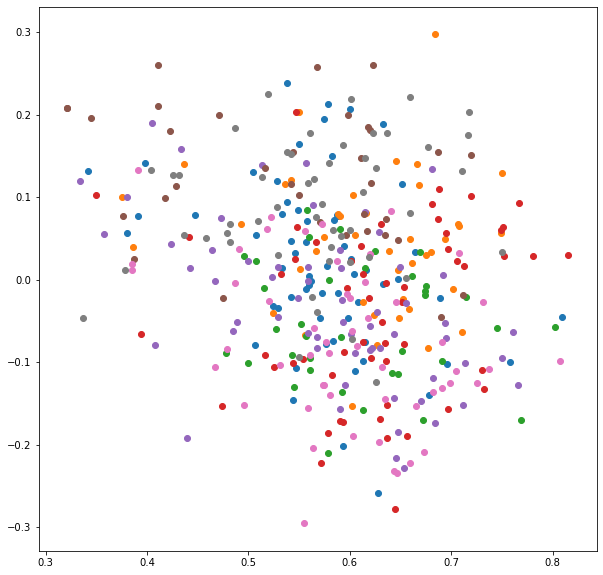

In [883]:
plt.figure(figsize=(10,10))
for cat in range(8):
    i = category_names[cat]
    target =  np.array(corpus_by_episode.category)
    plt.scatter(lsa_features[target == i, 0], lsa_features[target == i, 1])

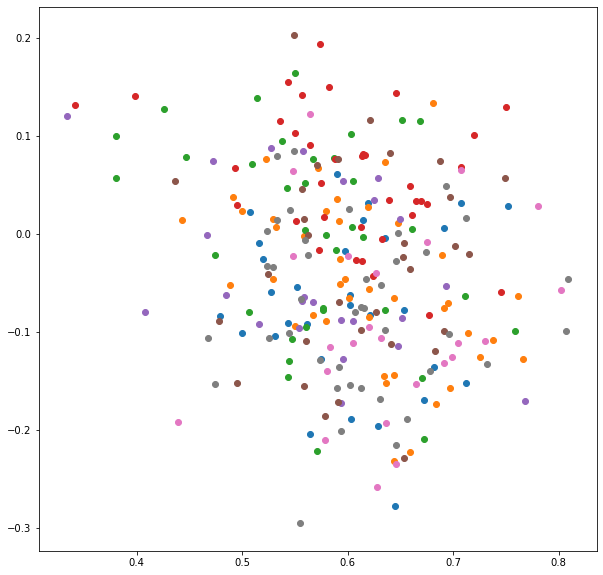

In [888]:
topic_names = list(set(corpus_by_episode.topic1))
plt.figure(figsize=(10,10))
for top in range(8):
    i = topic_names[top]
    target =  np.array(corpus_by_episode.topic1)
    plt.scatter(lsa_features[target == i, 0], lsa_features[target == i, 1])

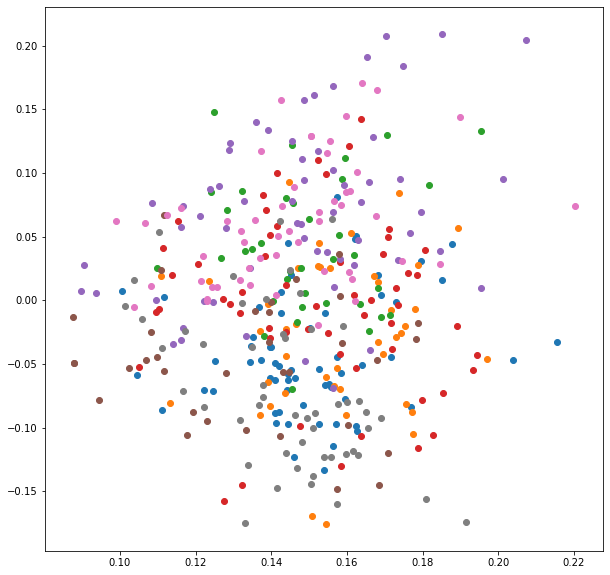

In [890]:
plt.figure(figsize=(10,10))
for cat in range(8):
    i = category_names[cat]
    target =  np.array(corpus_by_episode.category)
    plt.scatter(H_2[target == i, 0], H_2[target == i, 1])

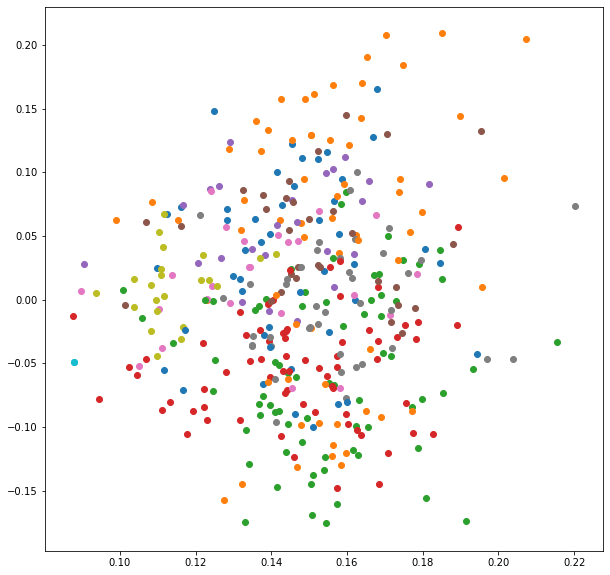

In [895]:
plt.figure(figsize=(10,10))
for top in range(14):
    i = topic_names[top]
    target =  np.array(corpus_by_episode.topic1)
    plt.scatter(H_2[target == i, 0], H_2[target == i, 1])

## Export to Tableau to explore more

In [928]:
corpus_by_episode['X_space'] =  H_2.T[0]

In [930]:
corpus_by_episode['Y_space'] =  H_2.T[1]

In [932]:
corpus_by_episode.to_csv('corpus_Tab.csv')

# Recommender
With the H matrix, used cosine similarity to find episodes with similar topics. 

In [937]:
cosH = cosine_similarity(H)

In [939]:
cosH = pd.DataFrame(cosH, index=H.index, columns=H.index)

In [951]:
cosH['Fraktur'].sort_values(ascending=False).head(7)

title
Fraktur                                                    1.000000
Interrobang                                                0.861281
Speech Bubbles: Understanding Comics with Scott McCloud    0.845159
Recognizably Anonymous                                     0.837987
Plaid: Articles of Interest #2                             0.830605
The Calendar                                               0.829922
Call Now!                                                  0.828374
Name: Fraktur, dtype: float64